In [1]:
from ola_models import * 
from ola_RNN import * 

import os, time, copy, math, re, json, pickle, random
import numpy as np
import pandas as pd

import torch, torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.ticker as ticker
%matplotlib inline 
import seaborn as sns

from functools import partial 

cuda_available = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda_available else "cpu")
print(f'''using device {device}''')

path = !pwd
path = path[0]
print(path)

using device cuda:0
/home/r2/Documents/RNNexp


In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [3]:
class LSTM(nn.Module):
    def __init__(self, x_sz, h_sz, c_sz):
        super(LSTM,self).__init__()
        self.x_sz = x_sz
        self.h_sz = h_sz
        self.c_sz = c_sz

        self.xh_lay  = nn.Linear(self.x_sz + self.h_sz, 2*self.h_sz)
        self.xhc_lay = nn.Linear(self.x_sz + self.h_sz + self.c_sz, 2*self.h_sz)
        
        self.ig_sig = nn.Sigmoid()
        self.fg_sig = nn.Sigmoid()
        self.og_sig = nn.Sigmoid()
        self.gg_tan = nn.Tanh()
        
        self.out_lay = nn.Linear(self.x_sz+self.h_sz,self.x_sz)
        self.softmax = nn.LogSoftmax(dim=1)   
            
    def forward(self,input,hidd,cell):        
        
        f"""elementwise-add input and hidden"""

#         x = self.x_lay(input)   
#         h = self.h_lay(hidd)           
#         x_i,x_f,x_o,x_g = x.chunk(4,1)
#         h_i,h_f,h_o,h_g = h.chunk(4,1)                
#         forget_gate = self.fg_sig(x_f + h_f)        
#         input_gate  = self.ig_sig(x_i + h_i)        
#         gate_gate   = self.gg_tan(x_g + h_g)         
#         output_gate = self.ot_sig(x_o + h_o)

        f"""concatenation of input, hidden and cell"""
        xh  = self.xh_lay(torch.cat((input,hidd), 1))
        xhc = self.xhc_lay(torch.cat((input,hidd,cell),1))
        
        forget_in, input_in = xh.chunk(2,1)
        gate_in, output_in  = xhc.chunk(2,1) 

        input_gate  = self.ig_sig(input_in)
        forget_gate = self.fg_sig(forget_in)
        output_gate = self.og_sig(output_in)
        gate_gate   = self.gg_tan(gate_in)        
    
        new_cell    = cell * forget_gate + input_gate * gate_gate
        new_hidden  = output_gate * torch.tanh(new_cell) 
        
        combine = torch.cat((input,new_hidden),1)
        output  = self.out_lay(combine)
        
        return self.softmax(output), new_hidden, new_cell
    
    def batch_forward(self,xb,yb,h_c,loss_fn):        
        self.train()
        if xb[0,0,1].item() == 1: hidden, cell = self.initHidden(xb.shape[0])
        else: hidden,cell = h_c[0],h_c[1]
        loss = 0
        accu = 0
        for char in range(xb.shape[1]):
            x,y             = xb[:,char],yb[:,char]
            x,y,hidden,cell = unpad(x,y,hidden,cell)
            if x.shape[0] == 0: break
            output,hidden,cell = self.forward(x,hidden,cell)
            """divide by the bs used for current character"""
            accu += get_accu(output,y)/x.shape[0]    
            loss += loss_fn(output,y)
        return output,(hidden.detach(),cell.detach()),loss/(char+1),accu/(char+1)

    def initHidden(self, bs):
        return (cuda(torch.zeros(bs,self.h_sz)), cuda(torch.zeros(bs,self.c_sz)))

In [4]:
bs  = 30
sql = 30
lr  = 0.0005 

sched = combine_scheds([0.15, 0.25, 0.2, 0.4], [sched_cos(0.0005, 0.0008), sched_cos(0.0008, 0.0005),sched_lin(0.0005,0.0005),sched_cos(0.0005,0.00005)]) 
data          = pp_trumpdata(path+"/data/trump/", [0.9,0.95], bs)
data.train_dl = TweetDataLoader(data,data.train.tweets,bs,sql,shuffle=True)
data.valid_dl = TweetDataLoader(data,data.valid.tweets,bs,30,shuffle=False)

In [5]:
model  = cuda(LSTM(len(data.decoder), 150, 150))
opt    = optim.RMSprop(model.parameters(), lr, momentum=0.9)
learn  = Learner(model,  nn.NLLLoss(), opt , data, lr=lr)

In [6]:
cbs = CallbackHandler([CounterCallback(4000),StatsCallback()])

In [7]:
fit_rnn(1,learn,cbs)

learn.n_iters shouldn't be 0
getting validation
finished: 0.01250000000000001%
getting validation
finished: 0.02500000000000002%
getting validation
finished: 0.037500000000000026%
getting validation
finished: 0.05000000000000004%
getting validation
finished: 0.06250000000000004%
getting validation
finished: 0.07500000000000005%
getting validation
finished: 0.08750000000000006%
getting validation
finished: 0.10000000000000007%
getting validation
finished: 0.11250000000000009%
getting validation
finished: 0.12500000000000008%
getting validation
finished: 0.1375000000000001%
getting validation
finished: 0.1500000000000001%
getting validation
finished: 0.16250000000000012%
getting validation
finished: 0.17500000000000013%
getting validation
finished: 0.18750000000000014%
getting validation
finished: 0.20000000000000015%
getting validation
finished: 0.21250000000000016%
getting validation
finished: 0.22500000000000017%
getting validation
finished: 0.23750000000000018%
getting validation
fin

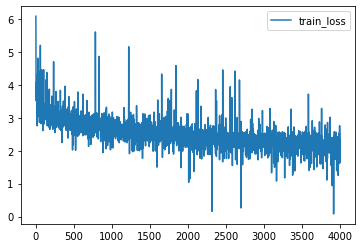

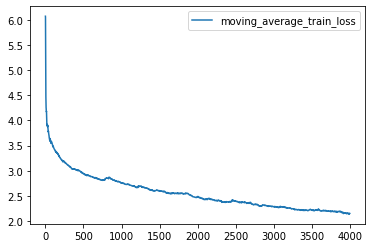

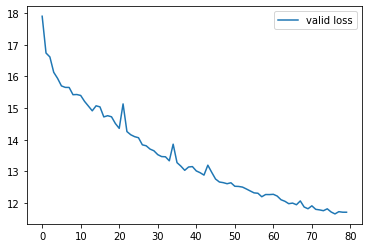

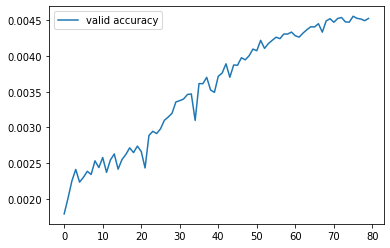

In [8]:
plot_list(learn.stats.train_loss, 'train_loss')
plot_list(learn.stats.train_mva_loss, 'moving_average_train_loss')
plot_list(learn.stats.valid_loss, 'valid loss')
plot_list(learn.stats.valid_accu, 'valid accuracy')

In [ ]:
learn.stats.train_mva_loss